<a href="https://colab.research.google.com/github/Charlotte-99/Y3Project/blob/main/Generating_an_Alpha_Map_Correct_Orientation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating an Alpha Map
In this notebook we will create a map of alpha values predicted by our CNN models using the real CMB data.

In [1]:
!pip install healpy

     |████████████████████████████████| 15.8MB 274kB/s 


In [2]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools

from matplotlib.colors import ListedColormap

In [3]:
import os

# Change directory
os.chdir('/content/drive/My Drive/Project')

## Extracting cutouts from the CMB
In this section, we will extract 5x5 degree squares from the CMB across the entire map. First we will load and preview the Planck map.

/usr/local/lib/python3.7/dist-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/usr/local/lib/python3.7/dist-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/usr/local/lib/python3.7/dist-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/usr/local/lib/python3.7/dist-packages/healpy/fitsfunc.py:426: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))
/usr/local/lib/python3.7/dist-packages/healpy/fitsfunc.py:428: UserWarn

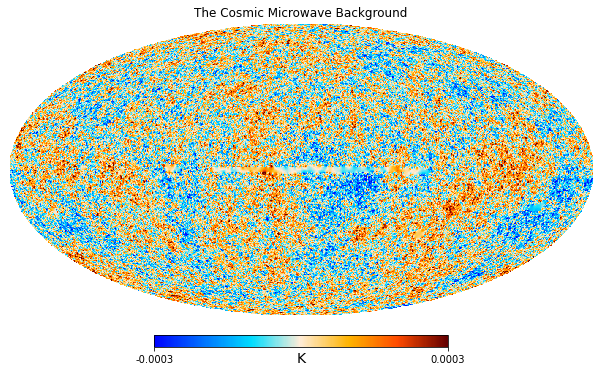

In [53]:
# Import and plot map
map = hp.fitsfunc.read_map('COM_CMB_IQU-smica_2048_R3.00_full.fits')
cmap = ListedColormap(np.loadtxt('planck_map.txt')/255.)

hp.mollview(map, title='The Cosmic Microwave Background', unit='K', cmap=cmap,
            min=-300e-6, max=300e-6)

Now we will create the list of longitude and latitude coordinates. These will be spaced out at 5 degree intervals.

Note that we are choosing the centres of the cutouts here, hence why we start at 2.5 longitude and not 0 longitude (and similarly with the latitude). This is so that it makes it easier to plot the map later on, as it avoids wrap-around issues (i.e. we'll be able to just plot an image that spans from 0 to 360 in width and 0 to 180 in height). 

In [54]:
# Create longitude and latitude list
lon_list = np.arange(-177.5, 182.5, 5)
lat_list = np.arange(-87.5, 92.5, 5)

coords = list(itertools.product(lon_list, lat_list))

Now we define our extraction function. This is exactly the same as we used before.

In [56]:
def extract_map(map, rot, deg_side, pixel_side):
  ''' This function extracts a map with shape (pixel_side, pixel_side) of a 
  deg_side x deg_side degree squared region from a map. 

  @params:
  map         a healpy map
  rot         a tuple (lon, lat, psi) where lon, lat specify where the
              centre of the extracted map will be and psi specifies a rotation.
              All in units of degrees.
  deg_side    number of degrees the side of the extracted map corresponds to
  pixel_side  size of the image side in pixels
  '''
  reso = 60*deg_side/pixel_side
  mini_map = hp.visufunc.gnomview(map, rot=rot, xsize=pixel_side,
                                  reso=reso, return_projected_map=True,
                                  no_plot=True)
  return mini_map

Now we can etxract the maps. We're not saving this to the Drive folder just to save on space (although it will mean we'll have to rerun this each time we open up the notebook). 

In [57]:
# Setup empty list to contain cutouts
num_maps = len(coords)
cutouts = [None]*num_maps

# Dimensions
pixel_side = 200
deg_side = 5

# Extract map
for n, (lon, lat) in enumerate(coords):
  cutouts[n] = extract_map(map, (lon, lat, 0), deg_side,
                             pixel_side)

# Convert to array and add channel dimension
cutouts = np.array(cutouts)
cutouts = cutouts[..., np.newaxis]

## Running the cutouts through the model

We can now load our model and create a dataset to output values of alpha.

In [58]:
# Load model
model = tf.keras.models.load_model('Standard_model_batchsize16_regularised')

In [59]:
def batch_standardisation(maps):
  epsilon = 1e-10
  mean, variance = tf.nn.moments(maps, axes=[0, 1, 2])
  denom = tf.math.sqrt(variance + epsilon)
  maps_standardised = (maps - mean)/denom
  return maps_standardised

Here we create our Planck dataset. We're still batching since we're using batch standardisation.

In [60]:
planck_ds = tf.data.Dataset.from_tensor_slices((cutouts))
planck_ds = planck_ds.batch(16)
planck_ds = planck_ds.map(batch_standardisation)

Now we can save our predictions to a variable. This will contain probabilities. 

In [61]:
# Save predictions
predictions = model.predict(planck_ds)

Here we find the categories with maximum probability.

In [62]:
predicted_indices = np.argmax(predictions, axis=1)
print(predicted_indices.shape)

(2592,)


We can also look at the percentage makeup. As we can see, there are lots of predictions for high values of alpha and fewer for low values of alpha.

In [63]:
unique, counts = np.unique(predicted_indices, return_counts=True)
percentages = counts/np.size(predicted_indices)*100
dict(zip(unique, percentages))

{0: 0.6172839506172839,
 1: 0.15432098765432098,
 2: 0.30864197530864196,
 3: 2.6234567901234565,
 4: 4.74537037037037,
 5: 22.2608024691358,
 6: 69.29012345679013}

Now we can extract the predicted values of alpha corresponding to the indices. 

In [64]:
alphas = [0, 5e-7, 1e-6, 2e-6, 3e-6, 4e-6, 5e-6]

# List of predicted alpha values
predicted_alphas = [alphas[i] for i in predicted_indices]

Here we begin setting up the array to contain our alpha values. First we create an array that has 180 rows and 360 columns. 

We also modify our map coordinates to turn them into row/column indices to make plotting easier.

In [66]:
alpha_map = np.zeros((180, 360))

plot_coords = np.array(coords)

# Add 177.5 from all longitude coordinates (so -177.5 becomes 0, etc.)
plot_coords[:, 0] += 177.5

# Add 87.5 to all latitude coordinates (so -87.5 becomes 0, etc.)
# This means our (0, 0) element of the array will correspond to (lon, lat) = (-177.5, -87.5)
plot_coords[:, 1] += 87.5

We now go though the map and assign alpha values to each cell of the map array. 

In [69]:
# Colour in map in 5x5 blocks.
for n, (X, Y) in enumerate(plot_coords):
  alpha_map[int(Y):int(Y)+5, int(X):int(X)+5] = predicted_alphas[n]

Now we plot the map.

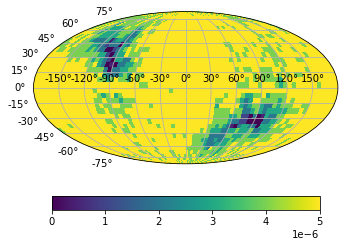

In [104]:
ax = plt.axes(projection='mollweide')

lon = np.flip(np.linspace(-np.pi, np.pi, 360))
lat = np.linspace(-np.pi/2., np.pi/2.,180)
Lon,Lat = np.meshgrid(lon,lat)
avg_cmap = ax.pcolormesh(Lon, Lat, alpha_map)
plt.colorbar(avg_cmap, orientation='horizontal', shrink=0.8)
plt.grid(True)
#plt.savefig('alpha_map.png', dpi=300, figsize=(10, 8), bbox_inches='tight')

Here we do the same as before, but with average alpha values to get a more smooth looking map.

In [76]:
average_alphas = np.array(predictions * alphas).sum(axis=1)
average_alpha_map = np.zeros((180, 360))

for n, (X, Y) in enumerate(plot_coords):
  average_alpha_map[int(Y):int(Y)+5, int(X):int(X)+5] = average_alphas[n]

Experimenting with the CMB map in Healpy has led us to notice that the longitude behaves different to what we expected. All positive values of longitude are actually negative and vice versa, i.e. lon = -60 is actually lon = 60. Thus, when we plot the map, we need to take this into account by effectively flipping the longitudinal coordindates.

Latitude coordinates behave as expected, so this does not need to change.

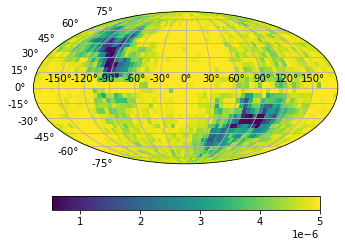

In [103]:
ax = plt.axes(projection='mollweide')

lon = np.flip(np.linspace(-np.pi, np.pi, 360))
lat = np.linspace(-np.pi/2., np.pi/2.,180)
Lon,Lat = np.meshgrid(lon,lat)
avg_cmap = ax.pcolormesh(Lon, Lat, average_alpha_map)
plt.colorbar(avg_cmap, orientation='horizontal', shrink=0.8)
plt.grid(True)
#plt.savefig('avg_alpha_map.png', dpi=300, figsize=(10, 8), bbox_inches='tight')

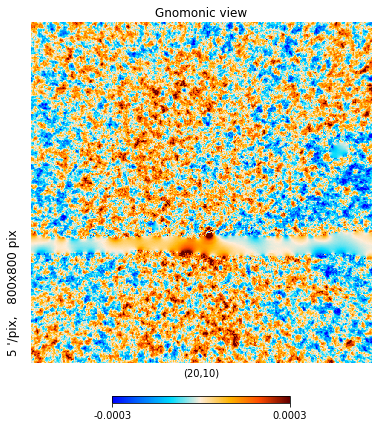

In [102]:
check = hp.visufunc.gnomview(map, rot=(20, 10, 0), xsize=800,
                                  reso=5, return_projected_map=True,
                                  no_plot=False, cmap=cmap, min=-300e-6, max=300e-6)